# URBAN HEALTH AND MEGACITIES: THE CASE OF NEW DELHI

![Title](Intro/img/header.png)

### Running environment:
* This notebook can be run by installing the provided Anaconda Python environment (**notebook-env.yml**).

# USE CASE 1: Nighttime Lights 
## Creating nighttime light maps with color blending

This use case demonstrates how to create **nighttime light variation maps** over a time interval (from 2019 to 2022) with additive color blending for studying the distribution of artificial lighting in urban and rural regions, offering insights into urbanization, infrastructure development, and socio-economic activity.
The Nighttime Light Levels indicator can be explored on the EO Dashboard by selecting the EXPLORE DATASETS mode and choosing [Night lights indicators](https://eodashboard.org/explore?indicator=NTLU&x=12142837.23019&y=4137471.98879&z=5.69238). 

The study has been carried out by Associate Professor *TOJO Bumpei* of the Institute of Global Studies (specializing in Geographic Information Systems) in collaboration with *JAXA*. 

![title](Nightlights/img/night_india.JPG)

Example of a nighttime light map covering India during 2019-2022, representing areas where a decrease in nighttime light level occurred (indicating a presumed reduction in social activity) in red, and areas where an increase occurred (indicating a presumed increase in social activity) in blue.

### 1.1 Input data
* Visible Infrared Imaging Radiometer Suite (VIIRS, onboard NASA Suomi NPP satellite).
* Aggregation: data aggregated on a semi-annual basis (using median image generation) with 10-degree lat/lon (geographic) grid h-v tile as Geo Tiff files.
* The tiles are 2400 x 2400 pixels, with pixel size of 0.004166 degrees (~464 m at the equator).
* Spatial Resolution: (0.4 - 0.8) km.
* Metric: nighttime radiance (measured in watts per square centimeter per steradian, [W/cm²/sr]), which represents the brightness of artificial lighting.
* Data access: aggregated input data provided by Jaxa and available locally

**VIIRS 10-degree tile scheme**

![VIIRS tiling scheme.JPG](Nightlights/img/VIIRS_tiling_scheme.jpg)



### 1.2 Importing Python libraries

In [1]:
#Import libraries
import os
import sys
import re
import numpy as np
import rasterio
import rioxarray as rxr
import subprocess
from subprocess import Popen, PIPE
import tempfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import json
from ipyleaflet import Map, ImageOverlay, basemaps

### 1.3 Defining working folders

In [2]:
input_dir = "input"
input_path = os.path.join(os.getcwd(), "Nightlights", input_dir)

output_urban = "output"
urban_path = os.path.join(os.getcwd(), "Nightlights", output_urban)

# Create output dir
os.makedirs(urban_path, exist_ok=True)

### 1.4 Visualizing input data

In [3]:
pattern = re.compile(r"h(\d+)v(\d+)_(\d{4})_(\d)H_median\.tif")

for root, _, files in os.walk(input_path):
    grouped_files = {}
    
    # Grouping files by h and v
    for file in files:
        match = pattern.match(file)
        if match:
            h, v, year, H = match.groups()
            key = (h, v)
            if key not in grouped_files:
                grouped_files[key] = []
            grouped_files[key].append((year, H, os.path.join(root, file))) 
    
    # Process files for plotting
    for (h, v), file_group in grouped_files.items():
        file_group

tuplelist2dict = {c:{'year':a,'half':b} for a,b,c in file_group}
sorted_dict = {}

grid_tile = None
for item in sorted(tuplelist2dict, key = lambda k: (tuplelist2dict[k]['year'], tuplelist2dict[k]['half'])):
    sorted_dict.update({item:tuplelist2dict[item]})
    grid_tile = item.split('/')[-1].split('_')[0]
#print(sorted_dict)

In [4]:
def plot_figures(figures, nrows = 1, ncols=1, factor = 1., clip_range = None, **kwargs):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15))
    for idx,file_name in enumerate(figures):
        title = file_name.split('/')[-1]
        title = title.replace("_median.tif", "")
        axeslist.ravel()[idx].imshow(np.clip(mpimg.imread(file_name)*factor, *clip_range), **kwargs) # cmap=plt.gray(), cmap='Greys'
        axeslist.ravel()[idx].set_title(title)
        axeslist.ravel()[idx].set_axis_off()
    fig.suptitle(r'Median nighttime light level [$Wcm^{-2}sr^{-1}$]', fontsize=20)
    #plt.tight_layout() 

    

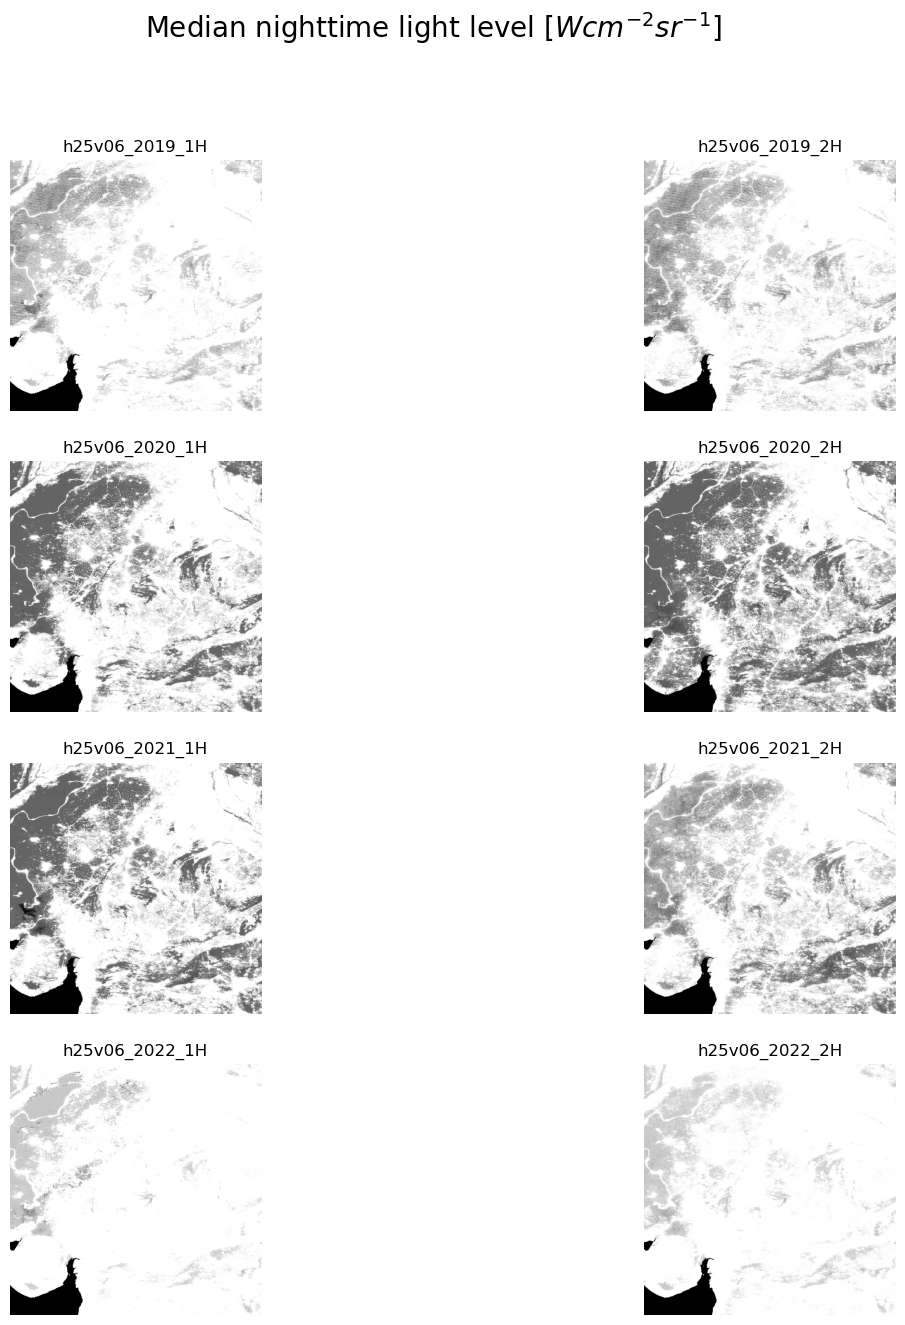

In [5]:
plot_figures(sorted_dict, 4, 2, clip_range=(0,1), factor=100./255.)

### 1.5 Applying color blending 

Additive color blending involves mixing the primary colors of light, red (R), green (G), and blue (B), while adjusting their luminance levels. By manipulating the luminance of these colors, a wide range of hues can be achieved, with the key characteristic being that combining all three colors results in white.

Technique
- maximum pixel value of images for 2019 (brightest pixel values) is assigned to red (R)
- minimum pixel value of images for 2020-2021 (darkest pixel values) is assigned to green (G)
- maximum pixel value of images for 2022 (brightest pixel values) is assigned to blue (B)

Output
- regions where a decrease in nighttime light level occurred are displayed in red
- areas that experienced an increase (presumed to indicate an increase in social activity) are shown in blue
- regions where there was no significant change throughout the pandemic are displayed in a gradient from gray to white.

In [6]:
pattern = re.compile(r"h(\d+)v(\d+)_(\d{4})_(\d)H_median\.tif")


def read_and_preprocess(file):
    with rasterio.open(file) as src:
        img = src.read(1)
        img = np.nan_to_num(img, nan=0)  # Replace NaNs with zeros
        return img, src.profile

    
def additive_blending(grouped_files):
    # Process each group of files for blending
    for (h, v), file_group in grouped_files.items():
        # Initialize arrays to store the maximum and minimum values for each year
        max_2019 = None
        min_2020_2021 = None
        max_2022 = None
        
        for year, H, file in file_group:
            img, profile = read_and_preprocess(file)
            
            if year == '2019':
                if max_2019 is None:
                    max_2019 = img
                else:
                    max_2019 = np.maximum(max_2019, img)
            elif year in ['2020', '2021']:
                if min_2020_2021 is None:
                    min_2020_2021 = img
                else:
                    min_2020_2021 = np.minimum(min_2020_2021, img)
            elif year == '2022':
                if max_2022 is None:
                    max_2022 = img
                else:
                    max_2022 = np.maximum(max_2022, img)
                                  
    # Create the blended image using the specified blending technique
    blended_img = np.zeros((max_2019.shape[0], max_2019.shape[1], 3), dtype=np.float32)
    blended_img[:, :, 0] = max_2019.astype(np.float32)  # Red band: maximum of 2019
    blended_img[:, :, 1] = min_2020_2021.astype(np.float32)  # Green band: minimum of 2020-2021 compared
    blended_img[:, :, 2] = max_2022.astype(np.float32)  # Blue band: maximum of 2022
    
    return blended_img, profile        

In [7]:
# Grouping files per (h,v) tiles and years span
grouped_files = {}
for root, _, files in os.walk(input_path):
    
    
    # Group files by h and v
    for file in files:
        match = pattern.match(file)
        if match:
            h, v, year, H = match.groups()
            key = (h, v)
            if key not in grouped_files:
                grouped_files[key] = []
            grouped_files[key].append((year, H, os.path.join(root, file)))


# blending           
blended_img, profile = additive_blending(grouped_files)

### 1.6 Employing "urban" stretch processing

The purpose of the stretch processing is to emphasize the nighttime light level of each band (corresponding to 2019, 2020-21, and 2022), focusing on:
- "urban" nighttime light levels: the display range of each band is adjusted to 25-1000 [watts·cm-2·sr-1], emphasizing brighter areas

In [8]:
# Urban stretch processing: Emphasize brighter areas
def urban_stretch_processing(band):
    min_val = 25
    max_val = 1000
    band = np.clip(band, min_val, max_val)
    band = (band - min_val) / (max_val - min_val) * 255
    return band.astype(np.uint8)

# Apply urban stretch processing to each band
blended_img[:, :, 0] = urban_stretch_processing(blended_img[:, :, 0])
blended_img[:, :, 1] = urban_stretch_processing(blended_img[:, :, 1])
blended_img[:, :, 2] = urban_stretch_processing(blended_img[:, :, 2])
        
# Update the profile for a 3-band image and set nodata value to None
profile.update(count=3, dtype=rasterio.uint8, nodata=None)

### 1.7 Plotting blended image

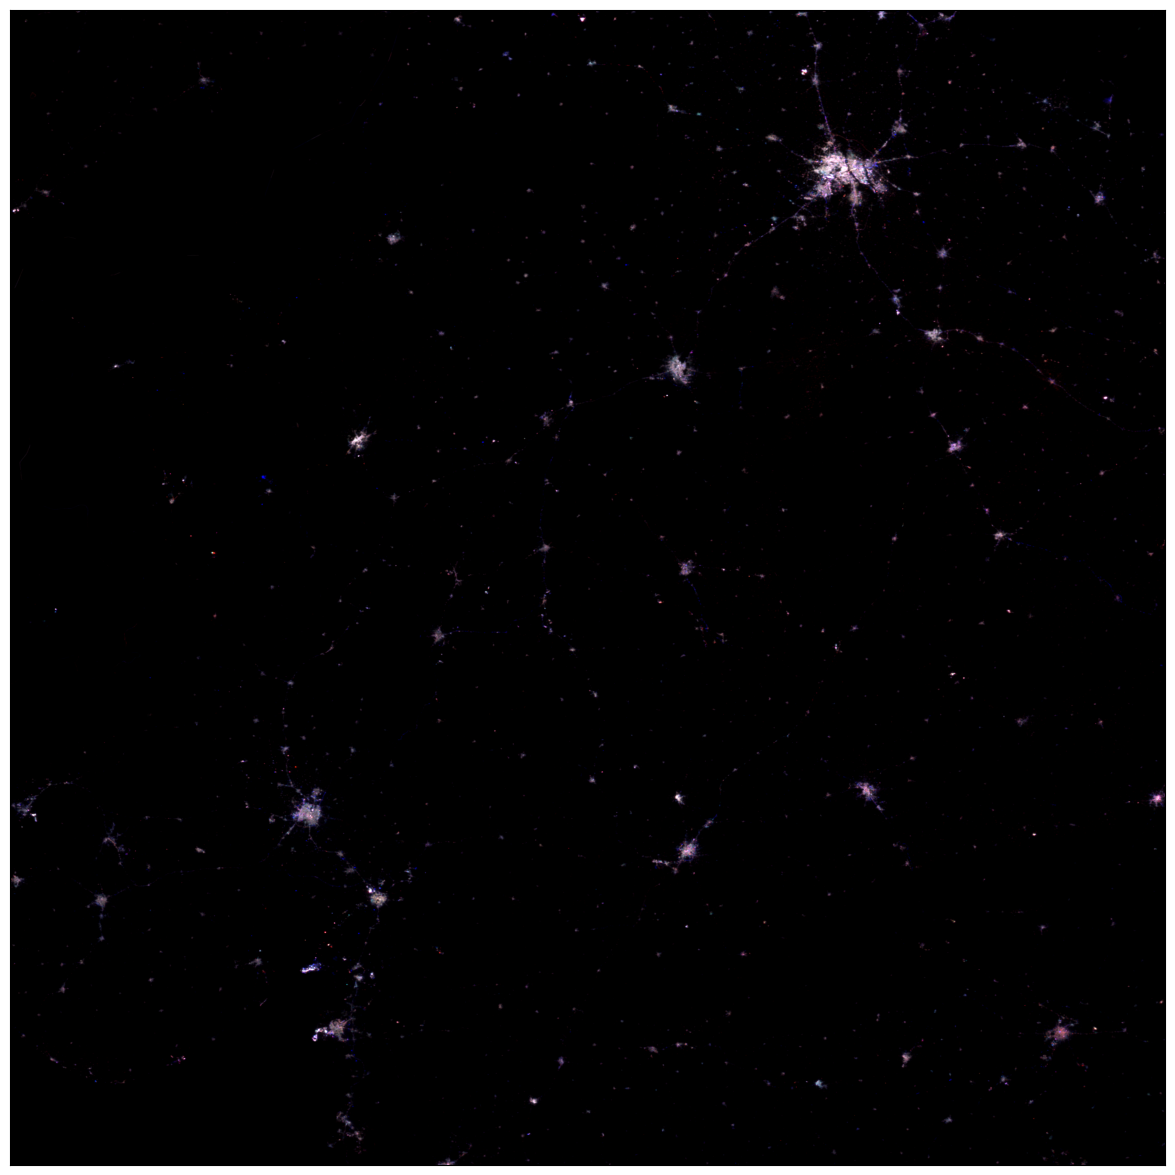

In [9]:
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])


plot_image(blended_img, factor=1.5/255., clip_range=(0,1))

### 1.8 Overlaying with an interactive map

Saving blended image as Cloud Optimized GeoTIFF

In [10]:
# Exporting output as COG file 
res_name = f"Nighttimelevel_Urban_{grid_tile}_2019-2022.tif"
output_cog = os.path.join(urban_path, res_name)


# Write the blended image directly to a temporary file
with tempfile.NamedTemporaryFile(suffix=".tif") as temp_file:
    with rasterio.open(temp_file.name, "w", **profile) as dst:
        dst.write(blended_img[:, :, 0], 1)
        dst.write(blended_img[:, :, 1], 2)
        dst.write(blended_img[:, :, 2], 3)

    subprocess.run([
        "gdal_translate", "-of", "COG",
        "-co", "COMPRESS=DEFLATE",
        "-co", "BLOCKSIZE=512",
        "-co", "RESAMPLING=NEAREST",
        "-co", "OVERVIEWS=IGNORE_EXISTING",
        temp_file.name,
        output_cog
    ])

print(f"COG file saved as {output_cog}")

Input file size is 2400, 2400
0...10...20...30...40...50...60...70...80...90...100 - done.
COG file saved as /home/lubojr/2025-BiDS-EODashboard/notebook/Nightlights/output/Nighttimelevel_Urban_h25v06_2019-2022.tif


Extracting bounding-box coordinates

In [11]:
p1 = Popen(["gdalinfo", "-json", output_cog, "-mm"], stdout=PIPE)
output = p1.communicate()[0]
dec_out = output.decode('utf-8')
j_str = json.loads(dec_out)
bbox = j_str['cornerCoordinates']
ll = bbox['lowerLeft']  # SW coo
ur = bbox['upperRight'] # NE coo
center = bbox['center']

Adding alpha channel to the blended image 

In [12]:
def almostEquals(a,b,thres=50):
    return all(abs(a[i]-b[i])<thres for i in range(len(a)))


image = Image.open(output_cog).convert('RGBA')
pixeldata = list(image.getdata())


for i,pixel in enumerate(pixeldata):
    if almostEquals(pixel[:3], (0,0,0)):
        pixeldata[i] = (0,0,0,0)


image.putdata(pixeldata)
png_path = os.path.join(urban_path, res_name.replace(".tif",".png"))
res = image.save(png_path)
#os.path.abspath(res)
abs_path = os.path.abspath(png_path)
work_dir = os.getcwd()
id_ = work_dir.split('/')[2]
base_url = os.path.join('https://hub-otc-sc.eox.at/user',id_,'files')
#base_url
abs_path = '/'.join(abs_path.split('/')[3:])
print(abs_path)
print(base_url)
#abs_path
print(os.path.join(base_url,abs_path))


2025-BiDS-EODashboard/notebook/Nightlights/output/Nighttimelevel_Urban_h25v06_2019-2022.png
https://hub-otc-sc.eox.at/user/lubojr/files
https://hub-otc-sc.eox.at/user/lubojr/files/2025-BiDS-EODashboard/notebook/Nightlights/output/Nighttimelevel_Urban_h25v06_2019-2022.png


Overlay with OpenStreetMap 

In [13]:
m = Map(basemap=basemaps.CartoDB.DarkMatter, center=(center[1], center[0]), zoom=6)
osm_url = os.path.join(base_url,abs_path)
image = ImageOverlay(url=osm_url,bounds=((ll[1], ll[0]), (ur[1], ur[0])))
m.add_layer(image);
m

Map(center=[25.0, 75.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

Using additive color blending images to focus on urban areas in India, in particular the North-West part comprising New Delhi, Jaipur, Agra, Gwalior, ...

### 1.9 Alternative stretch processing approaches

- "Rural" nighttime light levels: setting each band's display range to 0-50 [Watts·cm-2·sr-1] to emphasize darker areas
- For a broader focus (from rural to urban areas): applying a log10 transformation to the values of each band with a display range set to 0-3.6 (equivalent to 0-3981 [Watts·cm-2·sr-1])

### 1.10 Final remarks

This product has been specifically designed for utilization by researchers in applied scientific fields.
**Potential applications** are being explored in environmental and social issue studies, such as:
* **disaster recovery**
* **energy**
* **urban land use changes**
* **conflicts**
* **migration**
* **monitoring of illegal, unreported activities**

### To learn more

The presented approach is often referenced in scientific and public health research. For example, Bunpei Tojo (2021) used Nightlights data in the study "Application of Earth observation satellite data to public health: Comparison of night light (VIIRS) and solar radiation (SGLI) and domestic COVID-19 epidemic," presented at the 12th Federation of Science and Technology conference, to analyze the relationship between nighttime light intensity and public health factors.
https://doi.org/10.11487/oukan.2021.0_B-4-4.

# USE CASE 2: Air Pollution
##  Monitoring NO2 concentrations over Northern India

Air quality is poor across India, but especially poor in **Northern India** due to a mix of human activity and seasonal weather conditions:
* **Vehicle emissions**: The city's high population density results in heavy traffic and significant pollution from older and poorly maintained vehicles. Increased investment in mass transportation and stricter fuel efficiency enforcement could help mitigate these issues in future.
* **Industrial and construction dust**: Industrial operations and ongoing construction projects release fine particulate matter into the air.
* **Home heating**: Coal, firewood, and diesel generator use can contribute to poor air quality.
* **Weather patterns**: Chillier temperatures, low wind speeds, and heavy air trap pollutants close to the ground during colder months, worsening smog.
* **Crop stubble burning**: Farmers in neighboring states including Bihar, Haryana, and Uttar Pradesh burn agricultural waste, contributing to particulate pollution

Combined, these factors create a toxic atmosphere. Air quality is particularly dangerous during the winter months, when weather conditions exacerbate pollution.

![title](Air_pollution/img/Northern_India-air_pollution.JPG)


In particular, Delhi and large parts of North India experienced a significant **air quality crisis towards the end of 2024**, with air quality reaching the "Severe" and "Hazardous" categories, leading to a public health emergency.

This use case aims at analyzing the air quality over North India, showing how to create a **time series plot of mean tropospheric NO2 values** accompanied by the standard deviation to assess the impact of the pollutant agent.

The tropospheric NO2 concetrations can be further explored on the EO Dashboard by selecting the ATMOSPHERE Theme and choosing [Air Quality (tropospheric NO2 concentrations)](https://eodashboard.org/explore/?indicator=N1_NO2&x=0.0000&y=0.0000&z=2.6812&datetime=2025-06-23&template=expert).

### 2.1 Input data
* Tropospheric nitrogen dioxide (NO2) measurements obtained by TROPOMI (multispectral imaging spectrometer) aboard ESA Sentinel-5 Precursor (S5P) satellite (part of the European Copernicus programme)
* Aggregation: data combined over 14 days for averaging out meteorological daily variability
* Spectral bands: ultraviolet and visible (270–500 nm), near-infrared (675–775 nm) and shortwave infrared (2305–2385 nm)
* Resolution: (7 × 3.5) km
* Metric: micromoles per square meter [μmol/m²], total number of molecules of NO2 within a column of the atmosphere
* Data access: aggregated data collection available on Sentinel Hub as [Bring Your Own COG (BYOC)](https://docs.sentinel-hub.com/api/latest/data/byoc/) and accessed using Sentinel Hub APIs

### 2.2 Importing Python libraries

In [14]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import subprocess
import json
import requests
import pandas as pd
import os 
import IPython.display
from datetime import datetime
import matplotlib.pyplot as plt
from sentinelhub import BBox

### 2.3 Visualizing the AoI (Gurugram, South-West of New Delhi)

In [15]:
# Gurugram coordinates
top_left_x =  76.9602268594042
top_left_y = 28.5355222251629
bottom_right_x = 77.11128887112295 
bottom_right_y = 28.394875392026698

bbox = [   
  top_left_x,
  bottom_right_y,
  bottom_right_x,
  top_left_y
        ]

# Bbox EPSG
bbox_epsg = 4326

In [16]:
# Plotting the bounding box on a map

IPython.display.GeoJSON(BBox(bbox,crs=bbox_epsg).get_geojson())

<IPython.display.GeoJSON object>

### 2.4 Using Sentinel Hub statistical API request to access NO2 data collection for the selected AoI

The Statistical API (or shortly "Stats API") enables to get statistics calculated based on satellite imagery without having to download images.
In the **Statistical API request**, one can specify the following **inputs**:
* **area of interest (AoI)**
* **time period**
* **data collection** data collection id info on the publicly accessible [STAC catalog](https://esa-eodashboards.github.io/eodashboard-catalog/trilateral/catalog.json) (it can be also be queried via the pystac library as in this [example](https://eodashboard.org/notebook/?id=notebooks/eodashboard-stac-access/eodashboard-stac-access))
* **evalscript** or "custom script" is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return (more info [here](https://docs.sentinel-hub.com/api/latest/evalscript/v3/))
* **statistics to be calculated** are returned in the API response in a json format. Further details can be found on the corresponding [SH documentation](https://docs.sentinel-hub.com/api/latest/api/statistical/).

#### Defining Statistical API input parameters: AoI, time period, data collection

In [17]:
# AoI coordinates WGS84 (Gurugram)
bbox = [   
  top_left_x,
  top_left_y,
  bottom_right_x,
  bottom_right_y,
        ]

# Time period
date_from = "2024-11-01T00:00:00.000Z"
date_to = "2025-02-28T00:00:00.000Z"

# Data collection id
data_collection = "byoc-972e67a7-2ca8-4bf6-964a-11fe772e3ac2"

#### Defining Statistical API input parameters: custom script (evalscript)



Evalscript version 3 (V3) requires to specify two functions:
* setup: where you specify inputs and outputs.
* evaluatePixel: which calculates the output values for each pixel.

evaluatePixel() function must, in addition to other output, always return also dataMask output.
This output defines which pixels are excluded from calculations.

In [18]:
# Evalscript
evalscript="""
//VERSION=3
function setup() {
  return {
    input: [{bands: ["tropno2","dataMask"]}],
    output: [
      {
      id: "data",
      bands: 1,
      sampleType: "FLOAT32"
      },
      {
      id: "dataMask",
      bands: 1
      }]
    }
}

function evaluatePixel(samples) {
  let validValue = 1    // data sanitation
  if (samples.tropno2 >= 1e20 ){
    validValue = 0
    }
  let index = samples.tropno2;
  return {
    data:  [index],
    dataMask: [samples.dataMask * validValue]
    }
}
"""

#### Building NO2 data request 

In [19]:
data_req = {
  "input": {
    "bounds": {
      "bbox": bbox
    },
    "data": [
      {
        "dataFilter": {},
        "type": data_collection
      }
    ]
  },
  "aggregation": {
    "evalscript": evalscript,
    "timeRange": {
      "from": date_from,
      "to": date_to
    },
    "aggregationInterval": {
      "of": "P1D"
    },
    "width": 100,
    "height": 100
  },
  "calculations": {
    "default": {}
  }
}


#### Setting credentials for accessing Sentinel Hub services 
OAuth credentials to access SH services can be obtained by following the [instructions](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/) provided on the SH platform.

In [20]:
import os
# Creating a session
service_url = "https://services.sentinel-hub.com" # SH services endpoint

# OAuth Client configuration
client_id = os.environ.get("SH_CLIENT_ID")
client_secret = os.environ.get("SH_CLIENT_SECRET")

client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token_url = f"{service_url}/oauth/token" # Sentinel-Hub OAuth2 server token endpoint
token = oauth.fetch_token(token_url=token_url,
                          client_secret=client_secret)

#### Sending a POST request to SH Statistical API

In [21]:
stat_url = f"{service_url}/api/v1/statistics" # SH statistical API endpoint
resp = oauth.post(stat_url,
                  headers={"Accept":"application/json","Content-Type":"application/json"},
                  json=data_req)
#print(resp.status_code, resp.text)


#### Parsing response and extracting relevant statistics

In [22]:
# Extracting stats from timeseries data within the specified time interval
data_r = resp.json() # parsing response to json
time_axis = [datetime.strptime(entry["interval"]["from"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y/%m/%d") for entry in data_r["data"]]
means = [float(entry['outputs']['data']['bands']['B0']['stats']['mean']) for entry in data_r["data"]]
std_devs = [float(entry['outputs']['data']['bands']['B0']['stats']['stDev']) for entry in data_r["data"]]
std_upper = [m+s for (m,s) in zip(means, std_devs)]
std_lower = [m-s for (m,s) in zip(means, std_devs)]

### 2.5 Plotting the statistics for the NO2 timeseries

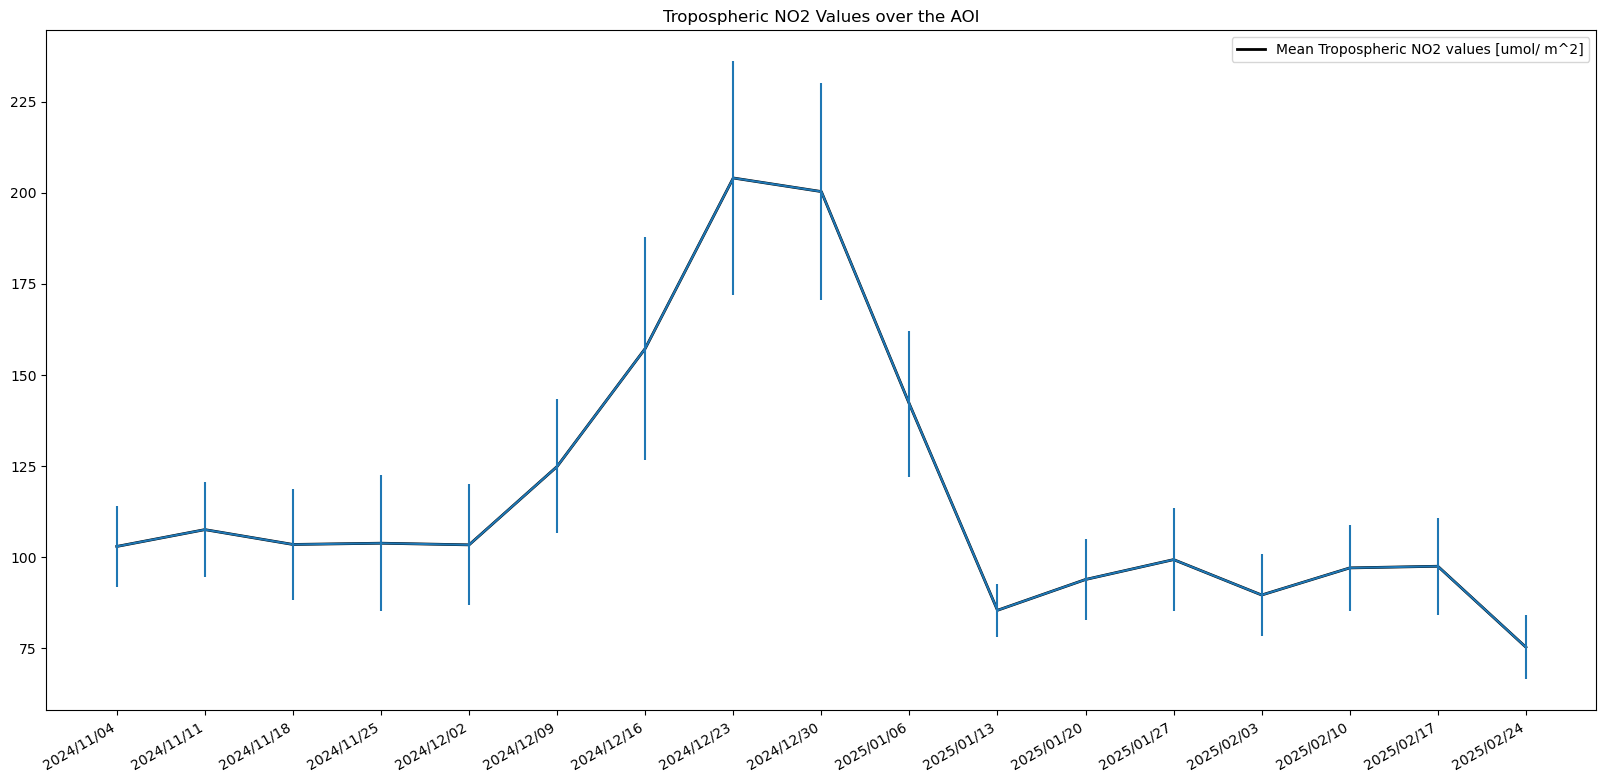

In [23]:
fig = plt.figure(figsize=(20,10))
# plot mean values 
plt.plot(time_axis, means, linestyle='solid', linewidth=2, color="black", label="Mean Tropospheric NO2 values [umol/ m^2]")

# plot standard deviation error bars
plt.errorbar(time_axis, means, yerr=std_devs, linestyle="-")

plt.title('Tropospheric NO2 Values over the AOI')
plt.legend()
fig.autofmt_xdate()

# Saving plot
output_no2 = "output"
output_no2_path = os.path.join(os.getcwd(), "Air_pollution", output_no2)
os.makedirs(output_no2_path, exist_ok=True)
plt.savefig(os.path.join(output_no2_path, 'NO2_Gurugram.png'))

plt.show()

The plot shows a spike in NO2 concentration over Gurugram in December 2024, when the significant air quality crisis in Northern India has been reported.
In particular, it can be noticed that the standard deviation starts increasing over this month with respect to the preceding and subsequent  time interval. 

### 2.6 Final remarks

The analysis carried out in this use case demonstrates how the *Sentinel-5 Precursor Copernicus mission* represents an essential contribution to monitoring air quality and providing critical information to services and decision makers to safeguard the everyday life of citizens.

In addition to nitrogen dioxide, the Tropomi spectrometer can map a multitude of trace gases such as:
* ozone
* formaldehyde
* sulphur dioxide
* methane
* carbon monoxide
* aerosols

all of which affect the air we breathe and therefore our **health**, and our **climate**.


# USE CASE 3: HEATWAVES
## Analyzing Land Surface Temperature with GCOM-C 'Shikisai' Satellite Data from JAXA

In this use case, we will explore **GCOM (Global Change Observation Mission)** satellite data to analyze **Land Surface Temperature (LST)**. Specifically, we’ll look at data from the **GCOM-C** satellite, which is part of the Japan Aerospace Exploration Agency’s (**JAXA**) efforts to monitor global climate change. GCOM-C provides valuable information on various environmental factors, including temperature, vegetation, and water bodies, through its thermal infrared sensors.
Our focus will be on studying the **heatwave** that occurred in **New Delhi, India, in 2024**. In particular, the city experienced a significant temperature surge during the peak summer months. The temperature exceeded **45°C (113°F)**, causing severe disruptions to daily life, and raising concerns about the increasing frequency and intensity of heatwaves due to climate change.
By analyzing GCOM-C's satellite data, we can better understand the spatial distribution of land surface temperature during that period.

![Title](https://th-i.thgim.com/public/incoming/ifa6rc/article68228316.ece/alternates/LANDSCAPE_1200/07_Standalone_Hot_Weather_Mirage_29_05_Delhi.jpg)

The July LST can be further explored on the [EO Dashboard ](https://eodash.github.io/preview-instance/?stacEndpoint=https%3A%2F%2Fesa-eodashboards.github.io%2Feodashboard-catalog%2Fpr-preview%2Fpr-80%2Ftrilateral%2Fcatalog.json&x=1.4778&y=9.5915&z=4.0973&datetime=2018-07-20&indicator=GCOM_global_monthly).



### 3.1 Input data
- Aggregation: Monthly **averaged global dataset for July 2024** (daytime measurements)
- Variable: **Land Surface Temperature (LST)** (which is a Level-2 product, calculating from two thermal infrared (TIR) bands  two TIR bands (10.8 µm & 12.0 µm) using a hybrid split-window + semi-analytical algorithm that accounts for emissivity and atmospheric effects.
- Spatial coverage: spatial coordinates 0°–90° East and 0°–90° North.
- Resolution: Approximately 1 km (spatial resolution of SGLI Level 3 products).
- Metric (units): Kelvin (°K) with scale factor of **0.02**, since: K = DN*0.02.
- Dataset documentation: https://suzaku.eorc.jaxa.jp/GCOM_C/data/ATBD/ver2/V2ATBD_T4A_LST_Moriyama_r1.pdf
- DOI: 10.57746/EO.01gs73bfs5sbzhyxg4j9ytajsa

### 3.2 Import libraries

In [24]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from osgeo import gdal
import requests
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.colors as mcolors

### 3.3 Defining working folders

In [25]:
output_urban = "output"
urban_path = os.path.join(os.getcwd(), "Heatwaves", output_urban)

# Create output dir
os.makedirs(urban_path, exist_ok=True)

### 3.4 Visualizing input dataset

#### Saving dataset locally from data endpoint
- This URL (data endpoint) contains a GeoTIFF file from LST and [**it's part of the EO Dashboard data ecosystem**](https://eodash.github.io/preview-instance/?stacEndpoint=https%3A%2F%2Fesa-eodashboards.github.io%2Feodashboard-catalog%2Fpr-preview%2Fpr-80%2Ftrilateral%2Fcatalog.json&x=1.4778&y=9.5915&z=4.0973&datetime=2018-07-20&indicator=GCOM_global_monthly)
- Dataset originally was generated in the [JAXA's G-Portal](https://data.earth.jaxa.jp/en/datasets/#/id/JAXA.G-Portal_GCOM-C.SGLI_standard.L3-AROT.daytime.v3_global_daily) and JAXA provides direct access to this and other COGs through their Earth API
- While these COGs differ between Level 0 and Level 1 data (meaning it is not yet possible to create composite layers), the **EO Dashboard** allows integration of raw Level 1 COGs hosted by JAXA ([example](https://eodash.github.io/preview-instance/?stacEndpoint=https%3A%2F%2Fesa-eodashboards.github.io%2Feodashboard-catalog%2Fpr-preview%2Fpr-80%2Ftrilateral%2Fcatalog.json&x=1.4778&y=9.5915&z=4.0973&datetime=2018-07-20&indicator=GCOM_global_monthly))

In [26]:
# Data endpoint
url = "https://s3.ap-northeast-1.wasabisys.com/je-pds/cog/v1/JAXA.G-Portal_GCOM-C.SGLI_standard.L3-LST.daytime.v3_global_monthly/2024-07/1/E000.00-E090.00/E000.00-N00.00-E090.00-N90.00-LST.tiff"
# Downloads the file from the URL
response = requests.get(url)
# Saves file locally 
with open("Heatwaves/LST.tiff", "wb") as f:
    f.write(response.content)

#### Plot the image

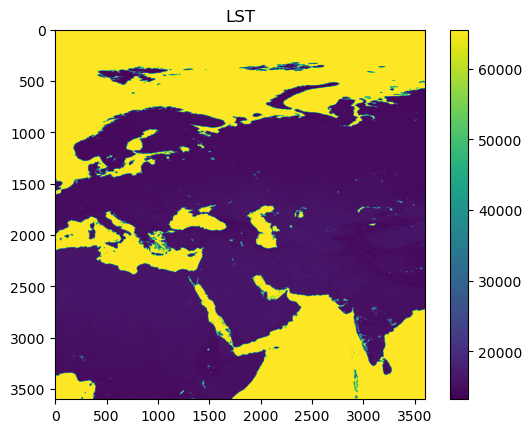

 - - - 
Aditional information about the dataset:
 - - - 
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] (0.0, 0.025, 0.0, 90.0, 0.0, -0.025)


In [27]:
# Opening the file with GDAL (library for geospatial raster data)
ds = gdal.Open("Heatwaves/LST.tiff")
# Gests the first (and in this case) only band refering to LST.
band = ds.GetRasterBand(1)
#Reads the raster into a NumPy array (a sort of matrix)
arr = band.ReadAsArray().astype(float)

# Plotting
import matplotlib.pyplot as plt
plt.imshow(arr, cmap="viridis")
plt.colorbar()
plt.title("LST")
plt.show()

print(' - - - ')
print('Aditional information about the dataset:')
print(' - - - ')
print(ds.GetProjection(), ds.GetGeoTransform())


### 3.4 Converting to Celsius Degrees and clean unvalid pixels
- The JAXA GCOM-C SGLI L3 LST had a 0.02 scalling factor and was in Kelvin.
- Removing values of pixels (consider them as NaN)


In [28]:
# Now we mask invalid or unrealistic values (sometimes satellite data have artifacts or other issues that render the value of a pixel wrong)
arr[(arr <= 0) | (arr > 35000)] = np.nan

# Re-scale and convert from Kelvin to Celsius
arr_c = arr * 0.02 - 273.15  

### 3.4 Croping to areas of interest: Northern India and New Dehli

#### Defining locations of interest

In [29]:
# GeoTransform is a GDAL function that helps map between the raster coordinates and georeference coordinates
# In other words it is converting geographic coordinates (lat, lon) into pixel coordinates of our matrix (X, y)
gt = ds.GetGeoTransform()
def latlon_to_pixel(lat, lon, gt):
    px = int((lon - gt[0]) / gt[1])
    py = int((lat - gt[3]) / gt[5])
    return px, py

# Now we use this function to get the pixel coordinates of an area around Northern India 
lon_min, lon_max = 70, 90
lat_min, lat_max = 20, 37
px_min, py_max = latlon_to_pixel(lat_min, lon_min, gt)
px_max, py_min = latlon_to_pixel(lat_max, lon_max, gt)
# 'Bounding box of northern India'
arr_crop_india = arr_c[py_min:py_max, px_min:px_max]

# We do the same for New Dehli
lon_min, lon_max = 76.8, 77.5
lat_min, lat_max = 28.4, 28.9
px_min2, py_max2 = latlon_to_pixel(lat_min, lon_min, gt)
px_max2, py_min2 = latlon_to_pixel(lat_max, lon_max, gt)
arr_crop_delhi = arr_c[py_min2:py_max2, px_min2:px_max2]

#### Plotting results  

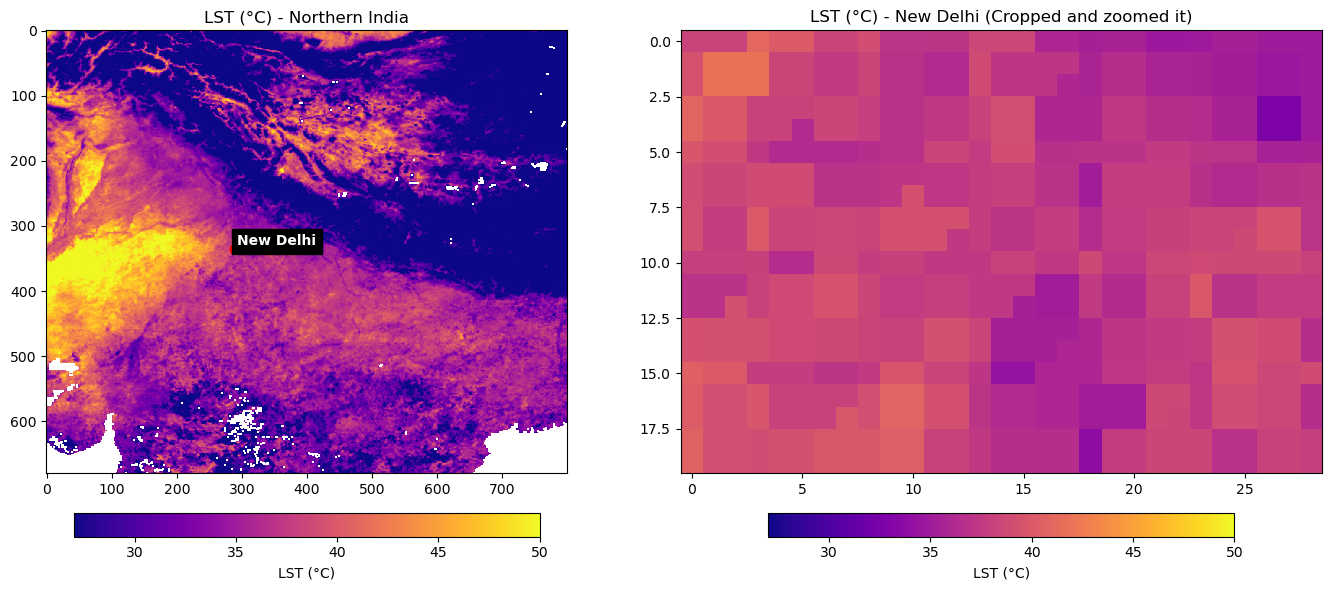

In [30]:
# Selecting the color scheme 
cmap = "plasma"  

# Settlings to ensure we have 2 plots, side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
vmin, vmax = 27, 50  

# 
im1 = axes[0].imshow(arr_crop_india, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title("LST (°C) - Northern India")
cbar1 = fig.colorbar(im1, ax=axes[0], orientation="horizontal", fraction=0.046, pad=0.08)
cbar1.set_label("LST (°C)")

# Mark New Delhi on Northern India map
delhi_lat, delhi_lon = 28.61, 77.21
px_delhi, py_delhi = latlon_to_pixel(delhi_lat, delhi_lon, gt)
px_delhi_rel = px_delhi - px_min
py_delhi_rel = py_delhi - py_min
axes[0].scatter(px_delhi_rel, py_delhi_rel, color="red", s=40, marker="o")
axes[0].text(px_delhi_rel + 5, py_delhi_rel - 5, "New Delhi", color="white",
             fontsize=10, weight="bold", backgroundcolor="black")

# Plot side-by-side
im2 = axes[1].imshow(arr_crop_delhi, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title("LST (°C) - New Delhi (Cropped and zoomed it)")
cbar2 = fig.colorbar(im2, ax=axes[1], orientation="horizontal", fraction=0.046, pad=0.08)
cbar2.set_label("LST (°C)")

plt.tight_layout()
plt.show()

### 3.5 Identifying locations where Heatwave has occured in June 2024
##### Defiyning the threshold:
- Applying a **threshold** (temperature limit from which it's considered to be a 'heatwave'): **40**

In [31]:
threshold = 40

##### Selecting the AoI
- From before we defined New Delhi **arr_crop_delhi** or northern india **arr_crop_india** 

In [32]:
arr_view = arr_crop_delhi

- Creating a **mask** with that value

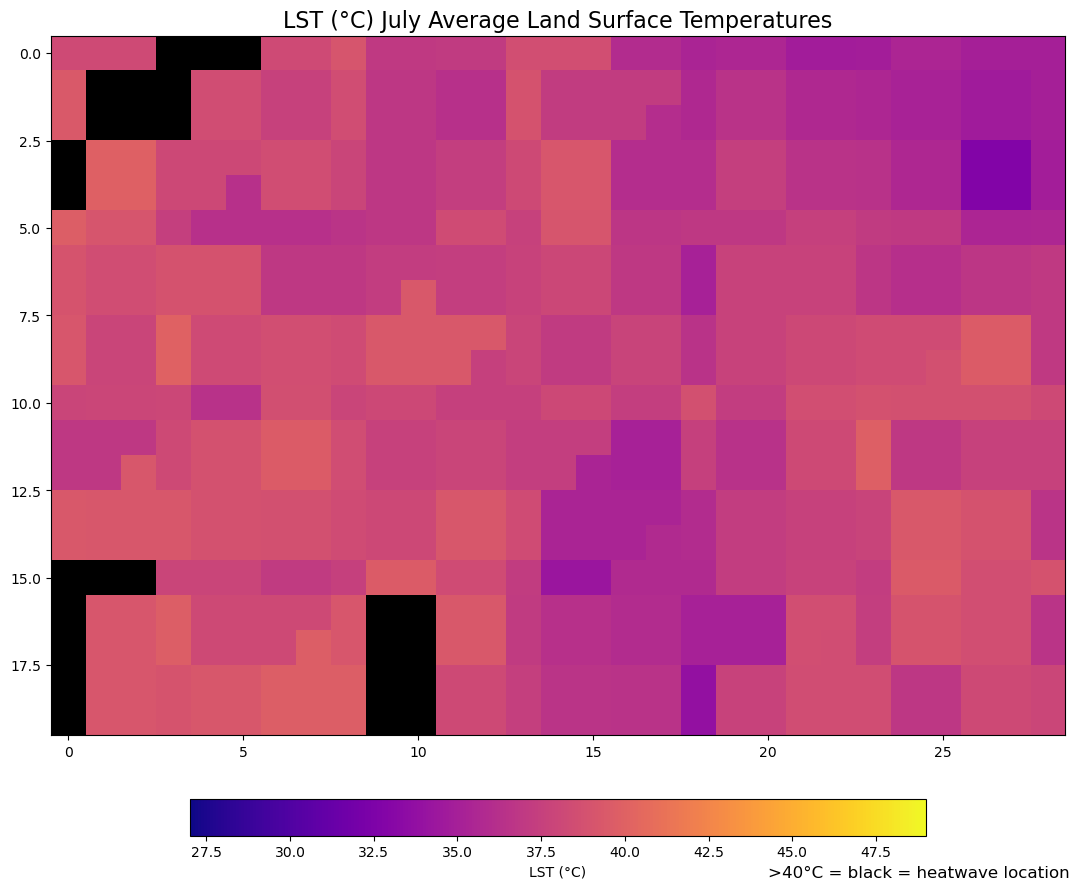

In [33]:
# Create a colormap from plasma
base_cmap = plt.cm.plasma
newcolors = base_cmap(np.linspace(0, 1, 256))
vmin, vmax = 27, 49

# Create a ListedColormap
cmap = mcolors.ListedColormap(newcolors)

# Create a mask for values > threshold
arr_masked = np.where(arr_view > threshold, np.nan, arr_view)

# Plot
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(arr_masked, cmap=cmap, vmin=vmin, vmax=vmax)

# Overlay black for pixels > threshold
ax.imshow(np.where(arr_view > threshold, 1, np.nan), cmap=mcolors.ListedColormap([[0,0,0,1]]))

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.046, pad=0.08)
cbar.set_label("LST (°C)")
cbar.ax.text(0.99, -0.99, f">{threshold}°C = black = heatwave location", color="black",
             fontsize=12, ha='center', va='center', transform=cbar.ax.transAxes)

# Title
ax.set_title("LST (°C) July Average Land Surface Temperatures", fontsize=16)


# Only show New Delhi if arr_view is arr_crop_india
if 'arr_crop_india' in globals() and arr_view is arr_crop_india:
    ax.scatter(px_delhi_rel, py_delhi_rel, color="red", s=100, marker="X")
    circle = patches.Circle((px_delhi_rel, py_delhi_rel), radius=40,
                            edgecolor='red', facecolor='none', linewidth=2.5)
    ax.add_patch(circle)
    ax.text(px_delhi_rel + 50, py_delhi_rel - 15, "New Delhi",
            color="white", fontsize=10, weight="bold", backgroundcolor="black")


plt.tight_layout()
plt.show()


### 3.6 Calculating areas (sqkm) affected within the selected area

In [34]:
# Mask pixels above threshold value
hot_pixels = arr_view > threshold

# Count pixels
num_hot_pixels = np.sum(hot_pixels)

# Assuming 1 km² per pixel
area_km2 = num_hot_pixels * 1  # 1 km² per pixel

print(f"Number of pixels > {threshold}°C: {num_hot_pixels}")
print(f"Total area > {threshold}°C: {area_km2} km²")

Number of pixels > 40°C: 26
Total area > 40°C: 26 km²


### 3.7 Final remarks

High Temperatures Around New Delhi
The highlighted region (New Delhi) shows elevated land surface temperatures, consistent with the reported heatwave where values exceeded 40 °C.
- Central and northwestern plains (yellow/orange shades) show much higher LST, typical of semi-arid and urbanized regions during peak summer.
- **Urban Heat Island Effect** - The dense, bright patch around New Delhi suggests an intensified heating effect compared to the surrounding rural areas, which may be attributed to urbanization, infrastructure, and reduced vegetation cover.
- In contrast, coastal and mountainous regions show a clear temperature contrast, indicating geographical control over heat distribution.

# USE CASE 4: URBAN HEALTH
## Assessing deprivation and poverty in New Dehli and Gurugram

This use case demonstrates how to **estimate deprivation and poverty of two cities**, using the **Global Gridded Relative Deprivation Index (GRDI), Version 1 dataset**. characterizes the relative levels of multidimensional deprivation and poverty where a **value of 100 represents the highest level of deprivation and a value of 0 the lowest**. GRDI is built from sociodemographic and satellite data inputs that were spatially harmonized, indexed, and weighted into six main components to produce the final GRDI layer. Inputs were selected from the best-available data that either continuously vary across space or have at least administrative level 1 (provincial/state) resolution, and which have global spatial coverage. GRDI has six input components, or dimensions, that are combined to determine the degree of relative deprivation:

- **Built-up to Non-built-up Area Ratio (BUILT)**: Lower ratios mean higher deprivation, as rural areas (with less built-up land) tend to face more poverty.
- **Child Dependency Ratio (CDR)**: Higher ratios mean higher deprivation, since more children depend on fewer working-age adults.
- **Infant Mortality Rate (IMR)**: Higher mortality rates signal higher deprivation.
- **Subnational Human Development Index (SHDI)**: Lower values mean higher deprivation in education, health, and living standards.
- **VIIRS Night Lights (VNL)**: Lower light intensity indicates higher deprivation, reflecting weaker economic activity and infrastructure.
- **VNL Slope (2012–2020)**: A positive slope (increasing brightness) implies decreasing deprivation; a negative slope implies increasing deprivation.

In this use case, we will compare both the **GRDI** and **VNL slope** specifically to the the cities of New Dehli and Gurugram.

<img src="https://thumbnails.openveda.cloud/grdi--dataset-cover.jpg" alt="Description" width="70%">


The Global Gridded Relative Deprivation Indexindicator can be explored on the EO Dashboard by selecting the EXPLORE DATASETS mode and choosing [GRDI Indicator](https://eodashboard.org/explore/?x=-0.0917&y=39.4096&z=2.4939&datetime=2010-01-01&template=expert&indicator=GRDI2). 





### 4.1. Input data (GRDI)
- Temporal Resolution: n/a ( single image resulting from the aggregation of 6 indicators collected within (2010-2020)
- Spatial Extent: Global
- Spatial Resolution: 30 arc-second (~1 km x 1 km)
- Data Units: relative level of multidimensional deprivation and poverty in each pixel represented as an index **from 0 to 100**
- DOI: https://doi.org/10.7927/3xxe-ap97
- Dataset documentation: https://www.earthdata.nasa.gov/data/catalog/sedac-ciesin-sedac-pmp-grdi-2010-2020-1.00#documents-and-resources

### 4.2 Import python libraries

In [35]:
import os
import requests
from IPython.display import Image
import mercantile
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import mercantile
import numpy as np
from shapely.geometry import Polygon, Point
#from pykml import parser
import matplotlib.pyplot as plt
#!pip install fastkml shapely
#!pip install pykml
import requests
import folium
from folium.raster_layers import ImageOverlay

### 4.3 Defining working folders

In [36]:
output_urban = "output"
urban_path = os.path.join(os.getcwd(), "Poverty", output_urban)

# Create output dir
os.makedirs(urban_path, exist_ok=True)

### 4.4. Visualizing the input data 

#### Query the STAC endpoint 
- GRDI dataset and all its 6 forming components [are part of the **EO Dashboard data ecosystem**: check the collections.](https://github.com/ESA-eodashboards/eodashboard-catalog/tree/main/collections) and explore them on the EO Dashboard:[GRDI](https://eodashboard.org/explore/?x=-0.0917&y=39.4096&z=2.3242&datetime=2010-01-01&template=expert&indicator=GRDI2); [Builtup Area](https://eodashboard.org/explore/?x=-0.0917&y=39.4096&z=2.3242&datetime=2015-01-01&template=expert&indicator=GRDI1); [Child Dependency Ratio](https://eodashboard.org/explore/?x=5.9701&y=49.2863&z=3.5875&datetime=2010-01-01&template=expert&indicator=GRDI8); [Infant Mortality Rates](https://eodashboard.org/explore/?x=-0.0917&y=39.4096&z=2.3242&datetime=2015-01-01&template=expert&indicator=GRDI7).
- The data endpoint in this case is not public accessible, but NASA VEDA allows to use a Tile Endpoint, which enables to show interactive map without downloading the full raster (VEDA API handles S3 authentication). VEDA endpoint is used by **EO Dashboard** that directly interacts with the services provided by VEDA, e.g. like rendering the image.

In [37]:
from pystac_client import Client

# STAC endpoint
stac_url = "https://openveda.cloud/api/stac/"
client = Client.open(stac_url)

# list available collections. 
# Uncomment below to see all collecions:
#collections = [c.id for c in client.get_collections()]
#print(collections[:])  # print all collections

#### Selection of collection
- Selecting which dataset to query

In [38]:
collection_id = "grdi-v1-raster"
#collection_id =  "grdi-v1-raster" or "grdi-vnl-slope-raster" or  'grdi-vnl-raster' or grdi-v1-built', 'grdi-v1-raster',"grdi-vnl-slope-raster" or

#### Query the STAC Endpoint with selected collection

In [39]:
search = client.search(collections=[collection_id], max_items=5)
items = list(search.items())

print(f"Found {len(items)} items")

# Look at the first item
item = items[0]
print("Item ID:", item.id)
print("Assets:", item.assets.keys())

cog_url = item.assets["cog_default"].href
print("Data endpoint: COG URL:", cog_url)

cog_url = item.assets["rendered_preview"].href
print("Rendered preview:", cog_url)

cog_path = item.assets.get("cog_default", None)
if cog_path is None:
    raise ValueError("No COG asset found for this item!")

cog_path = cog_path.href
print("COG PATH:", cog_path)

Found 1 items
Item ID: povmap-grdi-v1_2010-01-01_2021-12-31
Assets: dict_keys(['cog_default', 'rendered_preview'])
Data endpoint: COG URL: s3://veda-data-store/grdi-v1-raster/povmap-grdi-v1_2010-01-01_2021-12-31.tif
Rendered preview: https://openveda.cloud/api/raster/collections/grdi-v1-raster/items/povmap-grdi-v1_2010-01-01_2021-12-31/preview.png?assets=cog_default&rescale=0%2C100&colormap_name=viridis
COG PATH: s3://veda-data-store/grdi-v1-raster/povmap-grdi-v1_2010-01-01_2021-12-31.tif


#### Preview of data 

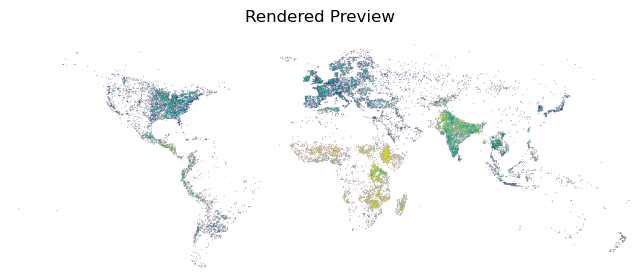

In [40]:
cog_preview_url = item.assets["rendered_preview"].href

response = requests.get(cog_preview_url)
img = Image.open(BytesIO(response.content))

plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.title("Rendered Preview")
plt.show()

#### Tile Endpoint
- Using Tile endpoint since in this case S3 path is not public
- The VEDA Tile endpoint generates Web Mercator map tiles from a Cloud-Optimized GeoTIFF (COG) for given z/x/y coordinates, applying optional resampling, band selection, colormap, and value rescaling.

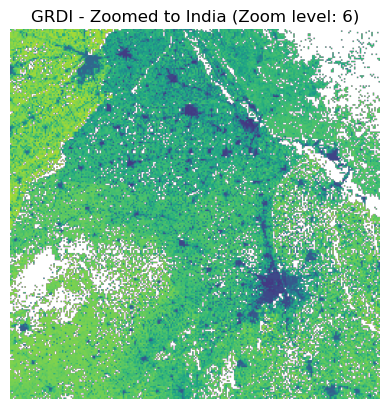

In [41]:
# Coordinates over India
lon, lat = 77.1025, 28.7041
zoom = 6

# Converts longitude and latitude into a tile in the Web Mercator grid
tile = mercantile.tile(lon, lat, zoom)

# Tile endpoint (which takes the COG and returns map tiles)
base_url = "https://openveda.cloud/api/raster/cog/tiles/WebMercatorQuad"

# Constructs the full url to request the tile image
tile_url = (
    f"{base_url}/{tile.z}/{tile.x}/{tile.y}"
    f"?url={cog_path}&resampling_method=nearest&bidx=1"
    f"&colormap_name=viridis&rescale=0,100"
)

# Request and plot the tile
response = requests.get(tile_url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.axis("off")
plt.title(f"GRDI - Zoomed to India (Zoom level: {zoom})")
plt.show()


### 4.4 Comparing two cities: New Delhi vs Gurugram 

#### Definition of the city boundaries
- Since we are comparing specifically the overall indicator of two distinct cities, we will try to focus on their admnistrative context
- You can hand-draw your own coordinates, or downdload kml or shapefile for your AoI

In [42]:
# Coordinates for cities 
newdelhi_nd = Polygon([(77.05010024928556, 28.545329632240488),(77.06932632350431, 28.527232785401164),(77.12151138209806, 28.493443691269704),(77.11052505397306, 28.458436437649425),(77.15172378444181, 28.435494362127248),(77.19292251491056, 28.4463622814295),(77.20253555201994, 28.472923604842666),(77.19292251491056, 28.497064469025712),(77.23961440944181, 28.5043056518795),(77.28355972194181, 28.530852403411522),(77.31102554225431, 28.545329632240488),(77.28767959498869, 28.571866050451412),(77.32201187037931, 28.574278120363793),(77.35085098170744, 28.6032186447749),(77.34398452662931, 28.633356550416348),(77.36321060084806, 28.65505048508341),(77.32475845241056, 28.73214811494396),(77.34398452662931, 28.777897949422616),(77.25884048366056, 28.786323363598065),(77.23961440944181, 28.730943901281826),(77.23686782741056, 28.705652209939004),(77.19841567897306, 28.729739673745172),(77.17094985866056, 28.751413646301874),(77.11876480006681, 28.768268071318303),(77.10365859889494, 28.751413646301874),(77.06245986842619, 28.724922624860923),(77.02812759303556, 28.67914959345852),(77.01027480983244, 28.638177812503272),(77.00478164576994, 28.593572688482055),(77.01988784694181, 28.569453925238474),(77.05010024928556, 28.545329632240488)])
gurugram_nd = Polygon([(77.03636733912931, 28.552567500585084),(77.06795303248869, 28.526026218441455),(77.10777847194181, 28.493443691269704),(77.11464492701994, 28.43066381740982),(76.99928848170744, 28.389595287262374),(76.97319595241056, 28.388387148302826),(76.92650405787931, 28.334006651363715),(76.87981216334806, 28.359387683848297),(76.89079849147306, 28.400467918290314),(76.92238418483244, 28.478959338289766),(76.96844764838063, 28.48499472683416),(77.00827308783376, 28.50792605695689),(77.00415321478688, 28.540504110335135),(77.03636733912931, 28.552567500585084)])
#ballabgarh_nd = Polygon([(77.305, 28.390),(77.315, 28.385),(77.325, 28.375),(77.330, 28.365),(77.320, 28.355),(77.310, 28.350),(77.300, 28.355),(77.295, 28.365),(77.295, 28.375),(77.300, 28.385),(77.305, 28.390)])
#ghaziabad_nd = Polygon([(77.380, 28.670),(77.400, 28.660),(77.420, 28.645),(77.435, 28.625),(77.430, 28.605),(77.410, 28.590),(77.390, 28.595),(77.370, 28.610),(77.360, 28.630),(77.365, 28.650),(77.380, 28.670)])

# Creating a dictionary of the cities to loop through them later
polygons = {
    "New Delhi": newdelhi_nd,
    "Gurugram": gurugram_nd
}

#### Fetch COG into tile
- Fetches COG map tiles for polygon-centered coordinates, crops them to the polygons, and overlays onto a Folium map


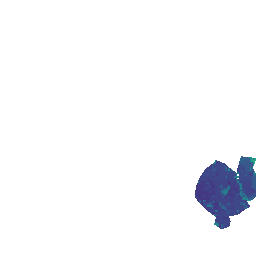
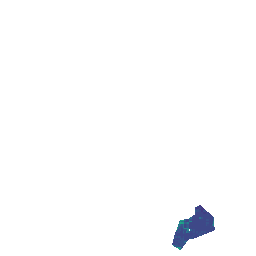

In [43]:

# This will fetch the map tile image of defined lon and lat and a cog_raster
def get_tile_image(lon, lat, zoom, cog_path, base_url):
    tile = mercantile.tile(lon, lat, zoom)
    url = (
        f"{base_url}/{tile.z}/{tile.x}/{tile.y}"
        f"?url={cog_path}&resampling_method=nearest&bidx=1"
        f"&colormap_name=viridis&rescale=0,100"
    )
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGBA")
    return np.array(img), tile

# Crops the tile into defined polygon
def crop_to_polygon(img_array, tile, polygon):
    height, width = img_array.shape[:2]
    lon_ul, lat_ul = mercantile.ul(tile.x, tile.y, tile.z).lng, mercantile.ul(tile.x, tile.y, tile.z).lat
    lon_lr, lat_lr = mercantile.ul(tile.x+1, tile.y+1, tile.z).lng, mercantile.ul(tile.x+1, tile.y+1, tile.z).lat
    res_lon = (lon_lr - lon_ul) / width
    res_lat = (lat_lr - lat_ul) / height

    mask = np.zeros((height, width), dtype=bool)
    for i in range(height):
        for j in range(width):
            lat_p = lat_ul + i * res_lat
            lon_p = lon_ul + j * res_lon
            if polygon.contains(Point(lon_p, lat_p)):
                mask[i, j] = True
    img_array[~mask] = [0, 0, 0, 0]
    return img_array

# --- Settings ---
zoom = 8
#base_url = "https://openveda.cloud/api/raster/cog/tiles/WebMercatorQuad"
#cog_path = "s3://veda-data-store/grdi-v1-raster/povmap-grdi-v1_2010-01-01_2021-12-31.tif"
# cog_path= "s3://veda-data-store/grdi-vnl-slope-raster/povmap-grdi-v1_VNL-slope_2012-01-01_2020-12-31.tif"



# Loop through each city to get the tile crop and plot
m = folium.Map(location=[28.55, 77.13], zoom_start=11)

for city, polygon in polygons.items():
    # Get approximate center of polygon for fetching tile
    lon, lat = polygon.centroid.x, polygon.centroid.y
    img, tile = get_tile_image(lon, lat, zoom, cog_path, base_url)
    img = crop_to_polygon(img, tile, polygon)

    # Overlay image
    ul_lat, ul_lon = mercantile.ul(tile.x, tile.y, tile.z).lat, mercantile.ul(tile.x, tile.y, tile.z).lng
    lr_lat, lr_lon = mercantile.ul(tile.x+1, tile.y+1, tile.z).lat, mercantile.ul(tile.x+1, tile.y+1, tile.z).lng
    ImageOverlay(image=img, bounds=[[lr_lat, ul_lon], [ul_lat, lr_lon]], opacity=0.6).add_to(m)

    # Add border
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in polygon.exterior.coords],
        color='red' if city=="New Delhi" else 'blue',
        weight=6,  # <-- thicker border
        fill=False
).add_to(m)

m

### 4.5 Estimating poverty (average values): New Delhi vs Gurugram 

In [44]:
# Fetch tile image 
def get_tile_image(lon, lat, zoom, cog_path, base_url):
    tile = mercantile.tile(lon, lat, zoom)
    url = (
        f"{base_url}/{tile.z}/{tile.x}/{tile.y}"
        f"?url={cog_path}&resampling_method=nearest&bidx=1"
        f"&colormap_name=viridis&rescale=0,100"
    )
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_array = np.array(img).astype(float)

    # Rescale if tile is in 0-255
    if img_array.max() > 100:
        img_array = img_array * (100.0 / 255.0)

    return img_array, tile

#  Generate boolean mask for each city/polygon
def polygon_mask(tile, polygon, img_shape):
    height, width = img_shape[:2]
    lon_ul, lat_ul = mercantile.ul(tile.x, tile.y, tile.z).lng, mercantile.ul(tile.x, tile.y, tile.z).lat
    lon_lr, lat_lr = mercantile.ul(tile.x+1, tile.y+1, tile.z).lng, mercantile.ul(tile.x+1, tile.y+1, tile.z).lat

    res_lon = (lon_lr - lon_ul) / width
    res_lat = (lat_lr - lat_ul) / height

    mask = np.zeros((height, width), dtype=bool)
    for i in range(height):
        for j in range(width):
            lon = lon_ul + j * res_lon
            lat = lat_ul + i * res_lat
            if polygon.contains(Point(lon, lat)):
                mask[i, j] = True
    return mask

# Compute average GRDI for each polygon
def compute_average_grdi(polygon, zoom=8):
    min_lon, min_lat, max_lon, max_lat = polygon.bounds
    tiles = list(mercantile.tiles(min_lon, min_lat, max_lon, max_lat, zoom))
    all_values = []

    for tile in tiles:
        lon = (mercantile.ul(tile.x, tile.y, tile.z).lng + mercantile.ul(tile.x+1, tile.y+1, tile.z).lng) / 2
        lat = (mercantile.ul(tile.x, tile.y, tile.z).lat + mercantile.ul(tile.x+1, tile.y+1, tile.z).lat) / 2

        img_array, tile = get_tile_image(lon, lat, tile.z, cog_path, base_url)

        mask = polygon_mask(tile, polygon, img_array.shape)
        all_values.extend(img_array[mask])

    return np.mean(all_values) if all_values else np.nan



#### Visualizing averaged values by city

Average GRDI for New Delhi: 51.64
Average GRDI for Gurugram: 52.01


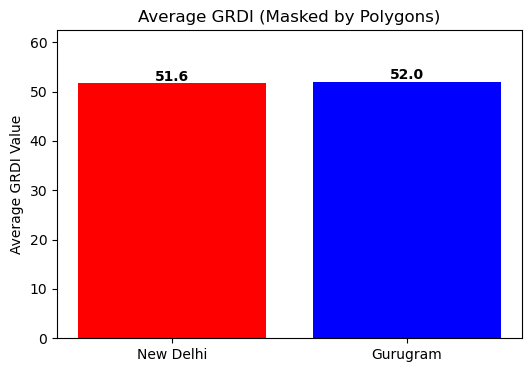

In [45]:
# Compute averages
averages = {city: compute_average_grdi(poly, zoom) for city, poly in polygons.items()}

# Print results
for city, avg in averages.items():
    print(f"Average GRDI for {city}: {avg:.2f}")

# Plot results
plt.figure(figsize=(6, 4))
plt.bar(averages.keys(), averages.values(), color=['red', 'blue'])
plt.ylabel("Average GRDI Value")
plt.title("Average GRDI (Masked by Polygons)")
for i, v in enumerate(averages.values()):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10, fontweight='bold')
plt.ylim(0, max(averages.values()) * 1.2)
plt.show()


#### Export graph results

In [46]:
# Sets location of output
output_file = os.path.join(urban_path, "average_grdi.png")

# --- Plot bar chart and save ---
plt.figure(figsize=(6, 4))
plt.bar(averages.keys(), averages.values(), color=['red', 'blue'])
plt.ylabel("Average Value")
plt.title("Average GRDI (Masked by Polygons)")
for i, v in enumerate(averages.values()):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10, fontweight='bold')
plt.ylim(0, max(averages.values()) * 1.2)

# Save figure
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.close()
print(f"Graph saved to: {output_file}")


Graph saved to: /home/lubojr/2025-BiDS-EODashboard/notebook/Poverty/output/average_grdi.png


### 4.5 Final remarks 

Overall GRDI values are 'mid'. Both New Delhi (51.6) and Gurugram (52) have GRDI values close to the middle on a 0–100 scale, **suggesting relative deprivation & proverty** . Gurugram **slightly higher than New Delhi, Gurugram’s average** higher than New Delhi could **indicate marginally worse development indicators**, but the difference is small—so not necessarily a large practical difference.

However, other indicators might indicate a relatively different result.